In [2]:
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
from binance.client import Client

In [13]:
def simulate_close(period, sigma, mu, initial_price, time):
    mu = mu * period # drift
    sigma = sigma * np.sqrt(period) # volatitlity
    delta = 1 / period

    wiener_process = sigma * np.random.normal(loc=0, scale=np.sqrt(delta), size=time)
    gbm = np.exp(wiener_process + (mu - sigma**2 / 2) * delta)
    simul = initial_price * gbm.cumprod(axis=0)
    return simul

def simulate_ohlc(close, period, sigma, time):
    ds = pd.DataFrame()
    ds["close"] = close
    ds["open"] = ds["close"].shift(1)
    mu = 0 # drift
    sigma = sigma * np.sqrt(period) # volatitlity
    delta = 1 / period

    wiener_process = sigma * np.random.normal(loc=0, scale=np.sqrt(delta), size=time)
    gbm_factor = np.exp(wiener_process + (mu - sigma**2 / 2) * delta) #log normale law
    gbm_factor = np.where(gbm_factor < 1, 1 / gbm_factor, gbm_factor)
    ds["high"] = gbm_factor * ds[['open', 'close']].max(axis=1)
    ds["low"] = gbm_factor * ds[['open', 'close']].min(axis=1)
    ds = ds.fillna(method='bfill')
    return ds

def generate_fake_data(df, period):
    # setup params for brownian motion
    initial_price = df.iloc[0]["close"]
    sigma = df["close"].pct_change().std()
    mu = df["close"].pct_change().mean()
    time = len(df)

    fake_close = simulate_close(period, sigma, mu, initial_price, time)

    sigma_high_low = ((df["high"] - df[['open', 'close']].max(axis=1)) / df[['open', 'close']].max(axis=1)).std() * 1.5
    fake_ohlc = simulate_ohlc(fake_close, period, sigma_high_low, time)
    fake_ohlc.index = df.index
    return fake_ohlc

In [11]:
client=Client(tld='us')

klinesT = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1HOUR, "2021-01-01", '2022-06-30')
df = pd.DataFrame(klinesT, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
del df['ignore']
del df['close_time']
del df['quote_av']
del df['trades']
del df['tb_base_av']
del df['tb_quote_av']
df['close'] = pd.to_numeric(df['close'])
df['high'] = pd.to_numeric(df['high'])
df['low'] = pd.to_numeric(df['low'])
df['open'] = pd.to_numeric(df['open'])
df['volume'] = pd.to_numeric(df['volume'])
df = df.set_index(df['timestamp'])
df.index = pd.to_datetime(df.index, unit='ms')
del df['timestamp']
df

,open,high,low,close,volume
timestamp,,,,,
2021-01-01 00:00:00,28933.86,29034.02,28708.39,29012.30,13.669080
2021-01-01 01:00:00,28999.37,29475.57,28961.27,29405.80,24.403112
2021-01-01 02:00:00,29434.69,29465.08,29122.75,29187.35,16.717015
2021-01-01 03:00:00,29213.39,29356.23,29149.88,29282.51,8.101748
2021-01-01 04:00:00,29280.63,29405.54,29071.86,29215.39,6.428110
...,...,...,...,...,...
2022-06-29 20:00:00,20218.71,20439.60,20124.95,20216.73,135.954615
2022-06-29 21:00:00,20230.98,20359.96,20197.66,20302.57,28.968957
2022-06-29 22:00:00,20303.17,20326.70,20150.69,20218.37,39.857942


In [14]:
ds = generate_fake_data(df, 365*24)
ds

C:\Users\antoi\AppData\Local\Temp\ipykernel_20716\2819314411.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ds = ds.fillna(method='bfill')


,close,open,high,low
timestamp,,,,
2021-01-01 00:00:00,28614.008694,28614.008694,28672.454487,28672.454487
2021-01-01 01:00:00,28722.842168,28614.008694,28727.423120,28618.572288
2021-01-01 02:00:00,29082.646396,28722.842168,29201.652507,28840.375961
2021-01-01 03:00:00,28943.383967,29082.646396,29273.660018,29133.482919
2021-01-01 04:00:00,29019.948041,28943.383967,29231.577480,29154.455058
...,...,...,...,...
2022-06-29 20:00:00,27620.922316,27550.852242,27797.075076,27726.558130
2022-06-29 21:00:00,27644.757391,27620.922316,27683.677780,27659.809147
2022-06-29 22:00:00,28126.588317,27644.757391,28238.073660,27754.332901


C:\Users\antoi\AppData\Local\Temp\ipykernel_20716\2819314411.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ds = ds.fillna(method='bfill')


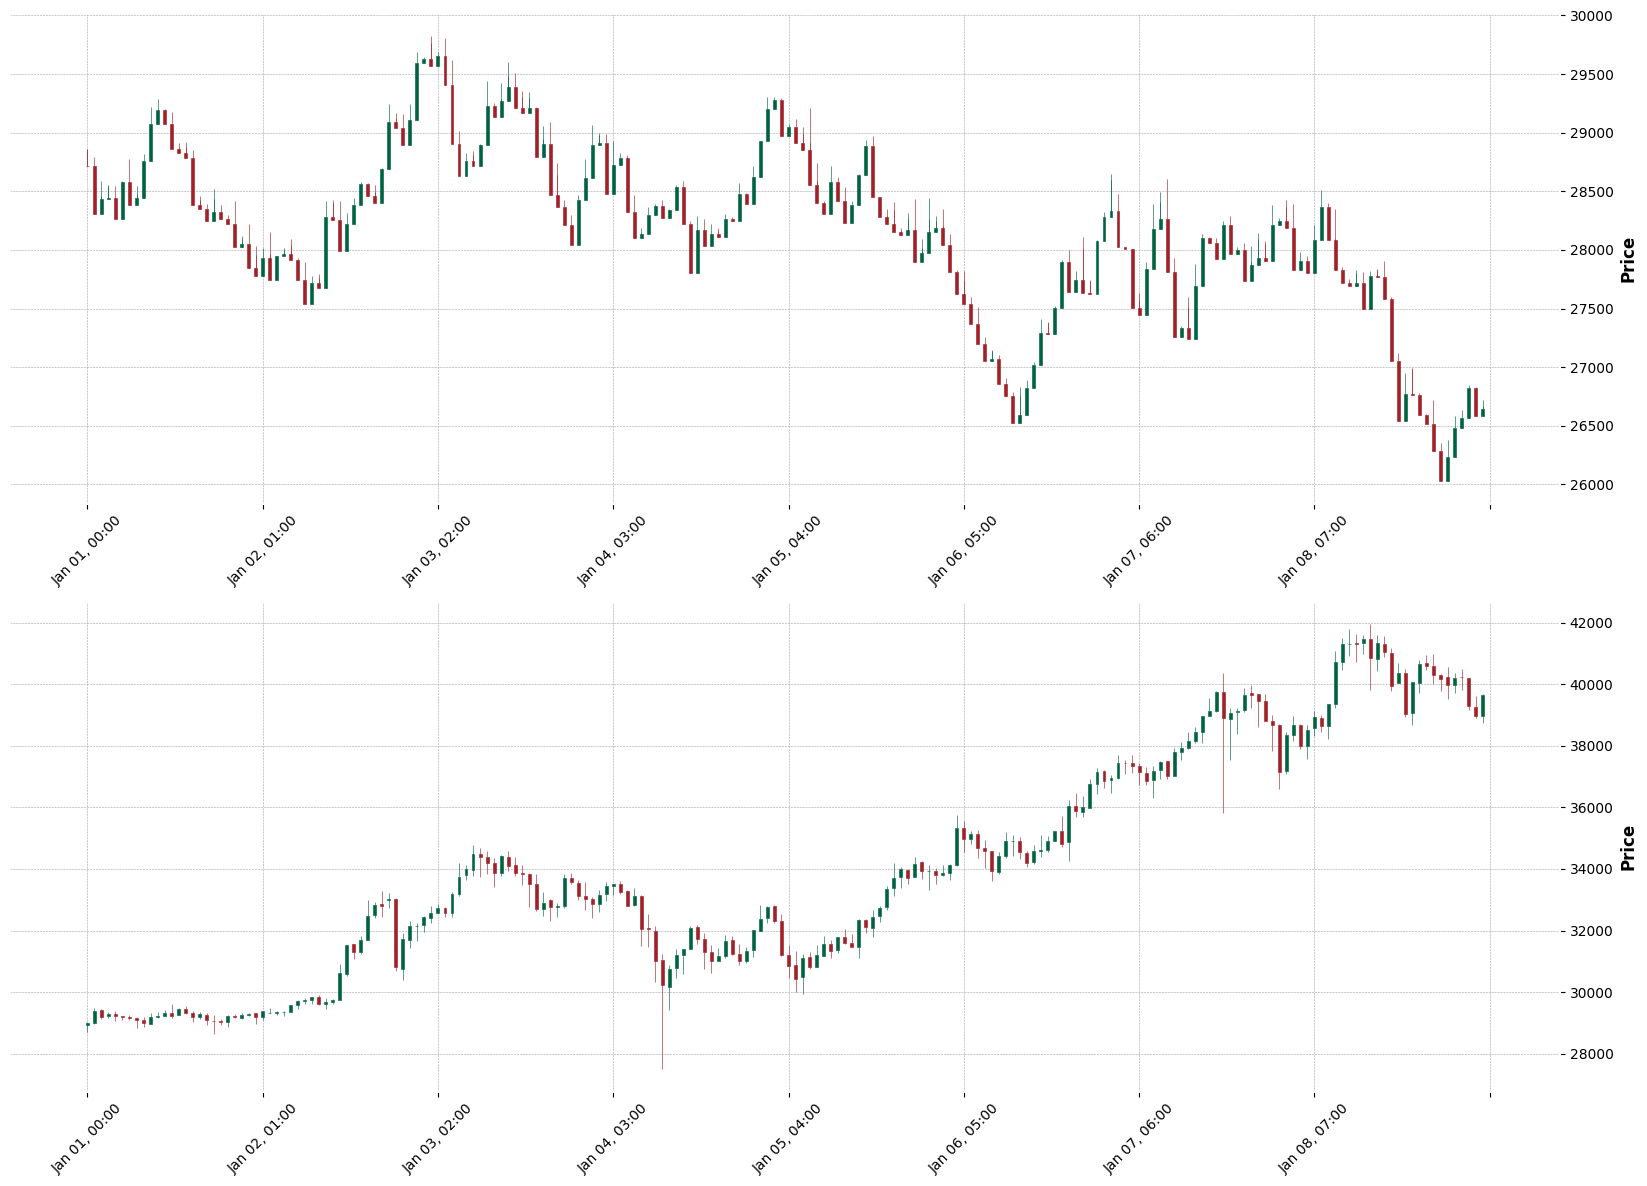

In [15]:
ds = generate_fake_data(df, 365)
fig = mpf.figure(1, figsize=(20, 14), style='charles')
axis = fig.subplots(2)
mpf.plot(ds.iloc[:200], type='candle', style='charles', ax=axis[0])
mpf.plot(df.iloc[:200], type='candle', style='charles', ax=axis[1])

C:\Users\antoi\AppData\Local\Temp\ipykernel_20716\2819314411.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ds = ds.fillna(method='bfill')


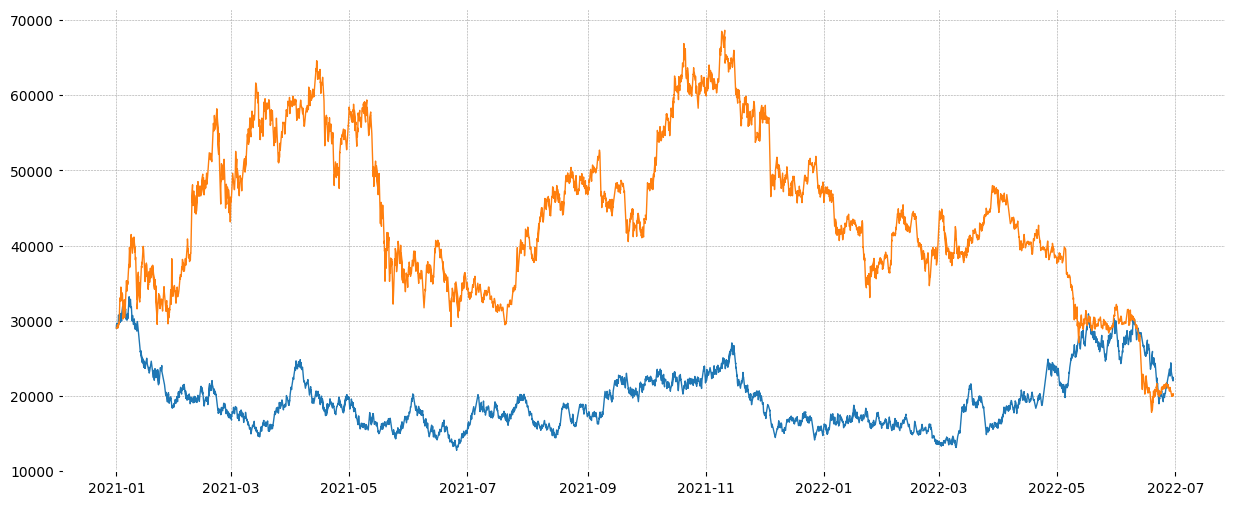

In [16]:
ds = generate_fake_data(df, 365)
fig, axes = plt.subplots(figsize=(15, 6))
axes.plot(ds["close"], linewidth=1)
axes.plot(df["close"], linewidth=1)
# axes.set_yscale("log")
plt.show()

C:\Users\antoi\AppData\Local\Temp\ipykernel_20716\2819314411.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ds = ds.fillna(method='bfill')
C:\Users\antoi\AppData\Local\Temp\ipykernel_20716\2819314411.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ds = ds.fillna(method='bfill')
C:\Users\antoi\AppData\Local\Temp\ipykernel_20716\2819314411.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ds = ds.fillna(method='bfill')
C:\Users\antoi\AppData\Local\Temp\ipykernel_20716\2819314411.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ds = ds.fillna(method='bfill')
C:\Users\antoi\AppData\Local\Temp\ipykernel_20716\28

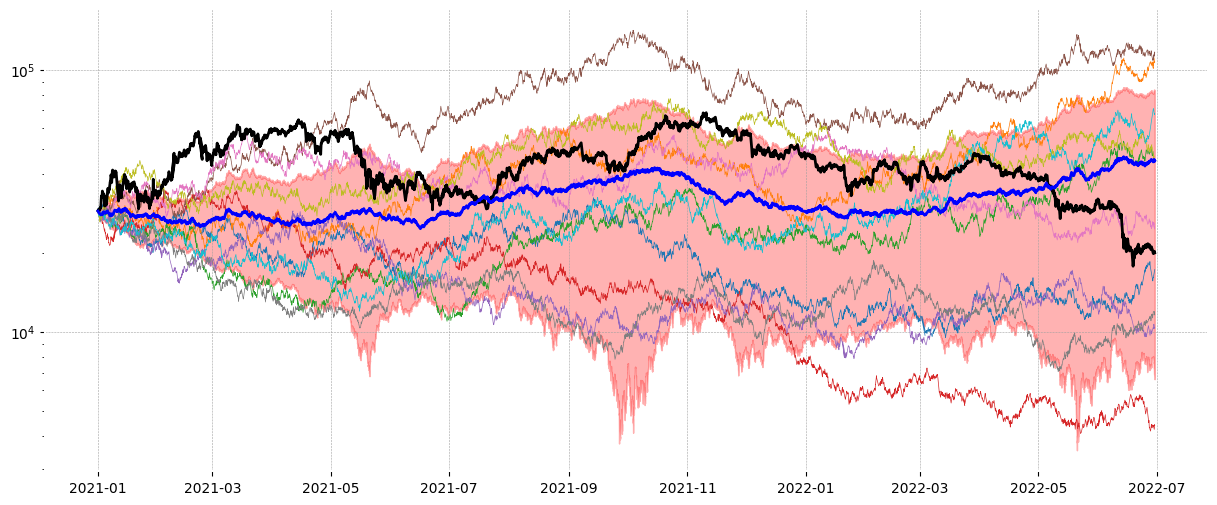

In [25]:
simulated_prices = []

fig, axes = plt.subplots(figsize=(15, 6))
axes.set_yscale("log")
for i in range(10):
    di = generate_fake_data(df, 365)
    simulated_prices.append(di['close'].values)
    axes.plot(di["close"], linewidth=0.5)
axes.plot(df["close"], linewidth=2, color="black")

simulated_prices = np.array(simulated_prices)
mean_prices = np.mean(simulated_prices, axis=0)
std_devs = np.std(simulated_prices, axis=0)

axes.plot(df.index, mean_prices, label='Moyenne des simulations', color='blue', linewidth=2)

axes.fill_between(df.index, mean_prices - std_devs, mean_prices + std_devs, color='red', alpha=0.3, label="Écart-type (±1)")

plt.show()